In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [2]:
from dask.distributed import Client
from glob import glob
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33197,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:41515,Total threads: 3
Dashboard: /proxy/45423/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:39969,


In [4]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))
measo_ind = xr.where((measo >= 13) & (measo <= 19), 1, np.nan)
measo_ind = measo_ind.dropna('xt_ocean','all')

#Checking result
measo_ind

<xarray.DataArray 'mask' (yt_ocean: 713, xt_ocean: 1400)>
array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0

In [5]:
measo_ind_coords = measo_ind.to_dataframe().reset_index().round(3)
measo_ind_coords

,yt_ocean,xt_ocean,mask
0,-79.968,30.05,1.0
1,-79.968,30.15,1.0
2,-79.968,30.25,1.0
3,-79.968,30.35,1.0
4,-79.968,30.45,1.0
...,...,...,...
998195,-45.036,169.55,NaN
998196,-45.036,169.65,NaN
998197,-45.036,169.75,NaN
998198,-45.036,169.85,NaN


In [6]:
pred_mod_best = pd.read_csv('../pred_mean_env_best_gam_model.csv')
pred_mod_best = pred_mod_best[['yt_ocean', 'xt_ocean', 'pred']] 

In [7]:
pred_mod_best

,yt_ocean,xt_ocean,pred
0,-71.478,169.95,2.220446e-16
1,-71.436,169.65,2.220446e-16
2,-71.436,169.75,2.220446e-16
3,-71.436,169.85,2.220446e-16
4,-71.436,169.95,2.220446e-16
...,...,...,...
573542,-45.107,139.55,1.000000e+00
573543,-45.107,139.65,1.000000e+00
573544,-45.107,139.75,1.000000e+00
573545,-45.107,139.85,1.000000e+00


In [8]:
grid_pred_mod_best = measo_ind_coords.merge(pred_mod_best, on = ['yt_ocean', 'xt_ocean'], how = 'left')
grid_pred_mod_best

,yt_ocean,xt_ocean,mask,pred
0,-79.968,30.05,1.0,NaN
1,-79.968,30.15,1.0,NaN
2,-79.968,30.25,1.0,NaN
3,-79.968,30.35,1.0,NaN
4,-79.968,30.45,1.0,NaN
...,...,...,...,...
998195,-45.036,169.55,NaN,NaN
998196,-45.036,169.65,NaN,NaN
998197,-45.036,169.75,NaN,NaN
998198,-45.036,169.85,NaN,NaN


In [9]:
mask_all = xr.DataArray(grid_pred_mod_best.pred.values.reshape(measo_ind.shape), 
                        dims = ['yt_ocean', 'xt_ocean'],
                        coords = {'yt_ocean': measo_ind.yt_ocean.values, 
                                  'xt_ocean': measo_ind.xt_ocean.values})


In [12]:
# crab = pd.read_csv('../Cleaned_Data/Obs_BG_5x_Indian_weaning_LowVIF.csv')
crab = crab.dropna()
crab

,date,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,...,depth_m,SIC,bottom_temp_degC,SSS_PSU,vel_lat_surf_msec,vel_lat_bottom_msec,vel_lon_surf_msec,vel_lon_bottom_msec,lt_pack_ice,dist_ice_edge_km
0,Nov-98,1998,11,-69.113,75.85,-69.092,75.8,autumn,weaning,1990,...,628.583313,0.649964,-1.846130,34.448925,-0.022099,0.005497,-0.086179,0.012248,0.595238,1007.829786
1,Nov-98,1998,11,-69.028,75.35,-69.049,75.3,autumn,weaning,1990,...,729.211975,0.681497,-1.842529,34.478040,-0.060345,-0.015542,-0.065018,0.007066,0.630952,996.341424
2,Nov-96,1996,11,-68.986,76.05,-69.007,76.0,autumn,weaning,1990,...,771.083313,0.630009,-1.853790,34.444534,-0.040797,0.012773,-0.030335,0.024060,0.595238,945.316770
3,Nov-98,1998,11,-68.606,75.45,-68.585,75.5,autumn,weaning,1990,...,657.066650,0.777837,-1.860046,34.473373,-0.018827,0.028036,-0.157301,-0.070906,0.630952,950.011791
4,Nov-98,1998,11,-68.395,75.35,-68.373,75.3,autumn,weaning,1990,...,578.416687,0.949461,-1.863617,34.532246,-0.003681,0.031602,-0.089833,-0.016668,0.630952,926.231709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,Nov-87,1987,11,-60.739,69.85,-60.763,69.9,autumn,weaning,1980,...,4415.736300,0.307505,-0.525208,33.781956,-0.021557,0.032602,0.022899,0.015693,0.000000,57.178165
13125,Dec-88,1988,12,-60.739,112.95,-60.763,112.9,summer,weaning,1980,...,4340.138700,0.001101,-0.273041,33.821957,-0.162214,-0.040941,0.017605,-0.009882,0.000000,350.553734
13126,Dec-99,1999,12,-60.147,72.85,-60.171,72.9,summer,weaning,1990,...,3646.319300,0.178314,-0.331696,33.736217,0.023296,-0.000208,0.038588,0.001406,0.011905,51.379618
13127,Dec-99,1999,12,-59.544,71.05,-59.569,71.1,summer,weaning,1990,...,4711.166500,0.027602,-0.528992,33.638540,0.075035,0.002422,0.199224,0.011736,0.000000,28.631353


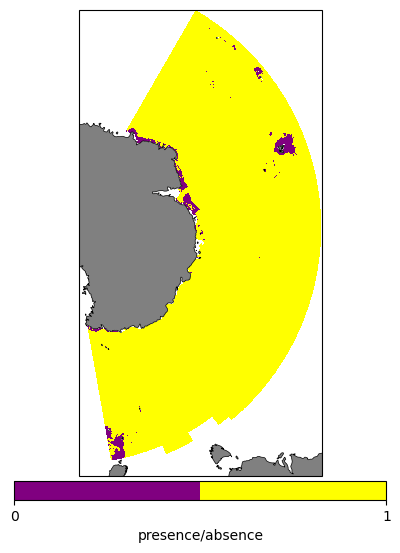

In [67]:
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize = (6.4*1.5, 4.8*1.5))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
land = cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
p = mask_all.plot(ax = ax, add_colorbar = False, cmap = ListedColormap(['purple', 'yellow']), transform = ccrs.PlateCarree())#, vmin = 0, vmax = 1)
# plt.scatter(x = crab.xt_ocean, y = crab.yt_ocean, s = 1, alpha = 0.5, transform = ccrs.PlateCarree())
ax.add_feature(land)
plt.colorbar(p, ticks = [0, 1], shrink = 0.5, label = 'presence/absence', orientation = 'horizontal', pad = 0.01)#, values = [0, 1])
# plt.savefig('../predictions_mod_wpoints.png', bbox_inches = 'tight')
plt.savefig('../predictions_mod.png', bbox_inches = 'tight')

In [62]:
pred_mod = pd.read_csv('../pred_mean_env_model.csv')
pred_mod = pred_mod[['yt_ocean', 'xt_ocean', 'pred']] 

In [63]:
grid_pred_mod = measo_ind_coords.merge(pred_mod, on = ['yt_ocean', 'xt_ocean'], how = 'left')
grid_pred_mod

,yt_ocean,xt_ocean,mask,pred
0,-79.968,30.05,1.0,NaN
1,-79.968,30.15,1.0,NaN
2,-79.968,30.25,1.0,NaN
3,-79.968,30.35,1.0,NaN
4,-79.968,30.45,1.0,NaN
...,...,...,...,...
998195,-45.036,169.55,NaN,NaN
998196,-45.036,169.65,NaN,NaN
998197,-45.036,169.75,NaN,NaN
998198,-45.036,169.85,NaN,NaN


In [64]:
pred_map = xr.DataArray(grid_pred_mod.pred.values.reshape(measo_ind.shape), 
                        dims = ['yt_ocean', 'xt_ocean'],
                        coords = {'yt_ocean': measo_ind.yt_ocean.values, 
                                  'xt_ocean': measo_ind.xt_ocean.values})


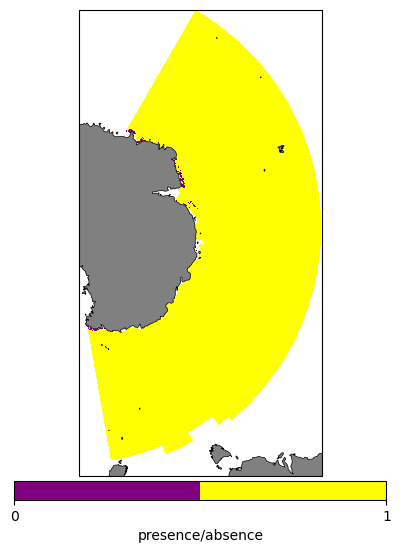

In [70]:
fig = plt.figure(figsize = (6.4*1.5, 4.8*1.5))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
land = cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
p = pred_map.plot(ax = ax, add_colorbar = False, cmap = ListedColormap(['purple', 'yellow']), transform = ccrs.PlateCarree())#, vmin = 0, vmax = 1)
# plt.scatter(x = crab.xt_ocean, y = crab.yt_ocean, s = 1, alpha = 0.5, transform = ccrs.PlateCarree())
ax.add_feature(land)
plt.colorbar(p, ticks = [0, 1], shrink = 0.5, label = 'presence/absence', orientation = 'horizontal', pad = 0.01)#, values = [0, 1])
# plt.savefig('../predictions_obs_wpoints.png', bbox_inches = 'tight')
plt.savefig('../predictions_obs.png', bbox_inches = 'tight')

## Observations

In [13]:
pred_obs_best = pd.read_csv('../obs-pred_mean_env_best_gam_model.csv')
pred_obs_best = pred_obs_best[['yt_ocean', 'xt_ocean', 'pred']] 

In [14]:
pred_obs_best

,yt_ocean,xt_ocean,pred
0,-71.478,169.95,NaN
1,-71.436,169.65,NaN
2,-71.436,169.75,NaN
3,-71.436,169.85,NaN
4,-71.436,169.95,NaN
...,...,...,...
573542,-45.107,139.55,1.0
573543,-45.107,139.65,1.0
573544,-45.107,139.75,1.0
573545,-45.107,139.85,1.0


In [15]:
grid_pred_obs_best = measo_ind_coords.merge(pred_obs_best, on = ['yt_ocean', 'xt_ocean'], how = 'left')
grid_pred_obs_best

,yt_ocean,xt_ocean,mask,pred
0,-79.968,30.05,1.0,NaN
1,-79.968,30.15,1.0,NaN
2,-79.968,30.25,1.0,NaN
3,-79.968,30.35,1.0,NaN
4,-79.968,30.45,1.0,NaN
...,...,...,...,...
998195,-45.036,169.55,NaN,NaN
998196,-45.036,169.65,NaN,NaN
998197,-45.036,169.75,NaN,NaN
998198,-45.036,169.85,NaN,NaN


In [17]:
mask_all = xr.DataArray(grid_pred_obs_best.pred.values.reshape(measo_ind.shape), 
                        dims = ['yt_ocean', 'xt_ocean'],
                        coords = {'yt_ocean': measo_ind.yt_ocean.values, 
                                  'xt_ocean': measo_ind.xt_ocean.values})
